In [1]:
#using Revise

In [1]:
using Knet

In [2]:
using ImageView;


(julia:10306): Gtk-WARNING **: 14:38:07.947: Theme parsing error: gtk.css:1521:23: 'font-feature-settings' is not a valid property name

(julia:10306): Gtk-WARNING **: 14:38:07.960: Theme parsing error: gtk.css:3460:25: 'font-feature-settings' is not a valid property name

(julia:10306): Gtk-WARNING **: 14:38:07.962: Theme parsing error: gtk.css:3922:23: 'font-feature-settings' is not a valid property name
Gtk-Message: 14:38:08.038: Failed to load module "canberra-gtk-module"
Gtk-Message: 14:38:08.038: Failed to load module "canberra-gtk-module"


In [1059]:
include("../helper.jl")
include("mpii.annotation.parser.jl")
include("accuracy.jl")
include("loss.jl")
include("mpii.batcher.jl")

merge_different_y (generic function with 1 method)

In [776]:
include("../models.jl")

In [1001]:
include("../training.jl")
include("../plots.jl")

draw_plots (generic function with 1 method)

In [1060]:
dtrn, dval = get_mpii_batches(32)

(8-element Data{Tuple{KnetArray{Float32,N} where N,KnetArray{Float32,N} where N}}, 1-element Data{Tuple{KnetArray{Float32,N} where N,KnetArray{Float32,N} where N}})

In [1064]:
# 5) Implementing a Convolutional Neural Network
simple_conv_net =   Chain(
    ResLayerConv(3, 3, 3, 8; stride=2, padding=1),
    ResLayerConv(3, 3, 8, 16; stride=2, padding=1),
    ResLayerConv(3, 3, 16, 32; stride=2, padding=1),
    Conv2(3, 3, 32, 32),
    ResLayerConv(3, 3, 32, 32; stride=2, padding=1),
    Deconv(3, 3, 14, 32; padding=1),
    loss=sigmoid_cross_entropy_loss
)

Chain((ResLayerConv(P(KnetArray{Float32,4}(3,3,3,8)), 1, 2), ResLayerConv(P(KnetArray{Float32,4}(3,3,8,16)), 1, 2), ResLayerConv(P(KnetArray{Float32,4}(3,3,16,32)), 1, 2), Conv2(P(KnetArray{Float32,4}(3,3,32,32)), P(KnetArray{Float32,4}(1,1,32,1)), Knet.Ops20.relu), ResLayerConv(P(KnetArray{Float32,4}(3,3,32,32)), 1, 2), Deconv(P(KnetArray{Float32,4}(3,3,14,32)), 1, 1)), 0, 0, sigmoid_cross_entropy_loss)

In [1065]:
simple_conv_net_results = trainresults("simple_conv_net.jld2", simple_conv_net, dtrn, dval, 1000, 0.15; accuracy_func=modelized_naive_pck_sigm, error_func=nothing);

┣████████████████████┫ [100.00%, 8000/8000, 01:38/01:38, 81.53i/s] 


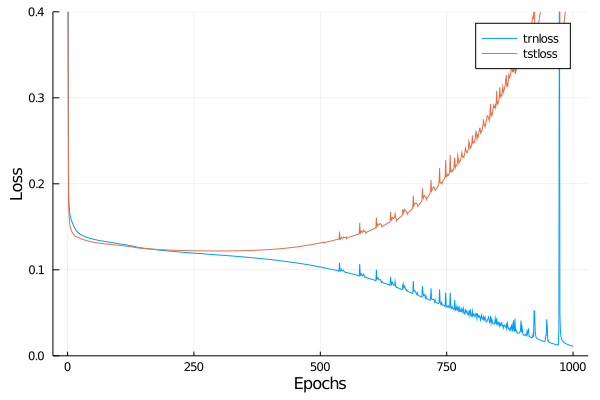

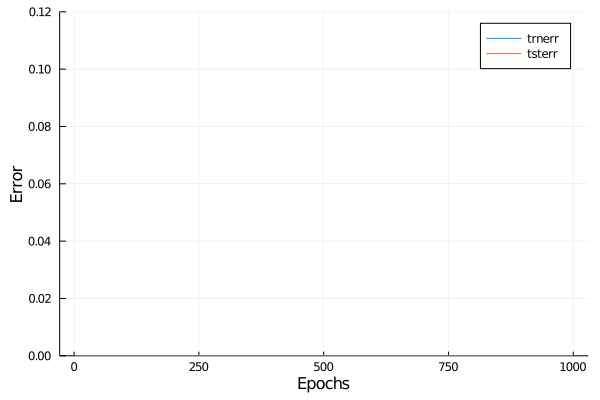

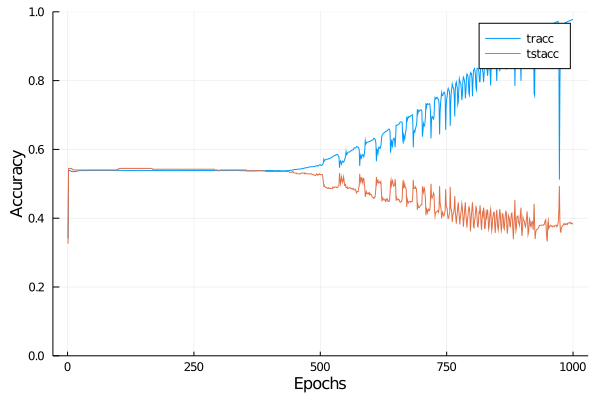

In [1066]:
draw_plots(simple_conv_net_results)

In [1073]:
dtrn_x1, dtrn_y1 = first(dtrn)
dval_x1, dval_y1 = first(dval)

(K32(128,128,3,32)[0.94509804⋯], K32(4,4,71,32)[0.0⋯])

In [1074]:
simple_conv_net(dval)

0.4599337f0

In [1075]:
sigmoided_output = Array(sigm.(simple_conv_net(dval_x1)));

In [1076]:
total_pck = naive_pck(sigmoided_output, dtrn_y1);
println(total_pck)

39.285714285714285


In [1054]:
function draw_first_images_forehead(y)
test_y = y[:, :, :, 9];
colorview(Gray, test_y[:, : , 11])
end

draw_first_images_forehead (generic function with 1 method)

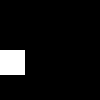

In [980]:
draw_first_images_forehead(ytrn)

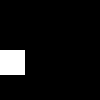

In [981]:
draw_first_images_forehead(sigmoided_output)

In [724]:
#draw_plots(simple_conv_net_results);

In [725]:
test_image = xtrn[:, :, :, 1];

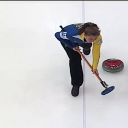

In [726]:
perm = permutedims(test_image, [3, 1, 2])
colorview(RGB, perm)
#colorview(RGB, rand(3,256,256))


In [235]:
size(ytrn)

(16, 16, 71, 64)

In [240]:
first(dtrn)[1] |> size

(128, 128, 3, 64)

In [241]:
first(dtrn)[2] |> size

(16, 16, 71, 64)

In [434]:
#julia> w0 = KnetArray(randn(Float32, 5, 5, 1, 20));

#julia> x0 = KnetArray(rand(Float32, 24, 24, 20, 100));

#julia> size(deconv4(w0,x0)) # this output does not make it sense, it should give what I want
#(28, 28, 20, 100)
#

w0 = KnetArray(randn(Float32, 5, 5, 1, 20));
 x0 = KnetArray(rand(Float32, 24, 24, 20, 100));

 # this output does not make it sense, it should give what I want
#(28, 28, 20, 100)

In [435]:
size(deconv4(w0,x0))

(26, 26, 1, 100)

In [244]:
tc = Conv2(3, 3, 3, 3)

Conv2(P(KnetArray{Float32,4}(3,3,3,3)), P(KnetArray{Float32,4}(1,1,3,1)), Knet.Ops20.relu)

In [392]:
fb = first(dtrn)[1];

In [393]:
res_tc = tc2(fb) |> tc;

In [437]:
mid = res_tc |> tc2

16×16×3×64 KnetArray{Float32,4}:
[:, :, 1, 1] =
  0.112997    0.0517907  0.0520545  0.0519588  …   0.0475755    0.0123551
  0.00921452  0.0132281  0.0129419  0.0123628      0.0150117   -0.0227738
  0.00826144  0.0145944  0.0121391  0.013257       0.0130657   -0.0205809
  0.0134121   0.0111661  0.0140461  0.0135455      0.0137847   -0.0215094
  0.01818     0.0129529  0.0131644  0.0133484      0.0142651   -0.0205225
  0.0140348   0.0133471  0.0134129  0.013993   …   0.0133054   -0.0204491
  0.0140647   0.0126312  0.0138596  0.0136938     -0.00172006  -0.0240447
  0.0125345   0.012157   0.0134645  0.0132168     -0.00509805  -0.0628166
  0.0131149   0.014411   0.0125145  0.0153247      0.052321     0.198369
  0.0142692   0.0131414  0.0128014  0.0122287      0.0531236   -0.000250595
  0.015522    0.0135363  0.0143546  0.0112565  …   0.0304594   -0.0201726
  0.0133763   0.0122032  0.0147571  0.0148027      0.0613541   -0.0199047
  0.0151913   0.0118998  0.0121954  0.0119745      0.013699    

In [439]:
w1 = KnetArray(randn(Float32, 3,3, 1, 3));

In [443]:
#deconv4(w1, mid)
size(deconv4(w1, mid; padding=1))

(16, 16, 1, 64)

In [249]:
tc2 = ResLayerConv(3, 3, 3, 3; stride=2, padding=1)

ResLayerConv(P(KnetArray{Float32,4}(3,3,3,3)), 1, 2)

In [264]:
res_tc2 = res_tc |> tc2;

In [265]:
size(res_tc)

(14, 14, 3, 64)

In [267]:
tc2(fb) |> tc2 |> tc2;